```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 107e7b61d352ed94ac752c0f9f74b0fddac13960 on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

In [4]:
%cuda_context_handler barotropic_gpu_ctx

In [5]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [6]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [8]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

Animation utils

In [9]:
import animation_utils

## Generating GPUOcean Simulation from Input

General parameters

In [10]:
dimY, dimX = ds.h.data.shape

In [11]:
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [12]:
t_start = 5*24
t_stop =  5*24 + 12

In [13]:
T = (t_stop-t_start)*3600  #Input

In [14]:
timestep_indices = [list(np.arange(t_start, t_stop+1))]

#### Initial conditions

In [15]:
barotropic_data_args, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.0, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

#### Test Simulations

In [16]:
barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [17]:
subt = 3600
for runt in range(int(T/subt)):
    barotropic_sim.step(subt)


In [18]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    anim = animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="GPUOcean")
    anim.save("anims/barotropic_test.mp4")

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


In [19]:
baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [20]:
subt = 3600
for runt in range(int(T/subt)):
    baroclinic_sim.step(subt)

In [21]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    anim = animation_utils.ncAnimation(baroclinic_sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="GPUOcean")
    anim.save("anims/baroclinic_test.mp4")

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Oslofjord/animation_utils.py:75: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  uv_cmap.set_bad("grey", alpha = 1.0)
/home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Oslofjord/animation_utils.py:78: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

In [34]:
from gpuocean.SWEsimulators import CombinedCDKLM16

sims = CombinedCDKLM16.CombinedCDKLM16(barotropic_sim=barotropic_sim, baroclinic_sim=baroclinic_sim)

In [35]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [36]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': sims.nx, 'ny': sims.ny,
                'domain_size_x': sims.nx*sims.dx,
                'domain_size_y': sims.ny*sims.dy,
                'land_mask': sims.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

In [37]:
initx = [ 6000]
inity = [12000]

num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

In [39]:
sims.attachDrifters(drifters)
trajectories.add_observation_from_sim(sims)

In [40]:
for hour in range(12):
    sims.combinedStep(3600.0, trajectory_dt=60, trajectories=trajectories)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  # Remove the CWD from sys.path while we load stuff.


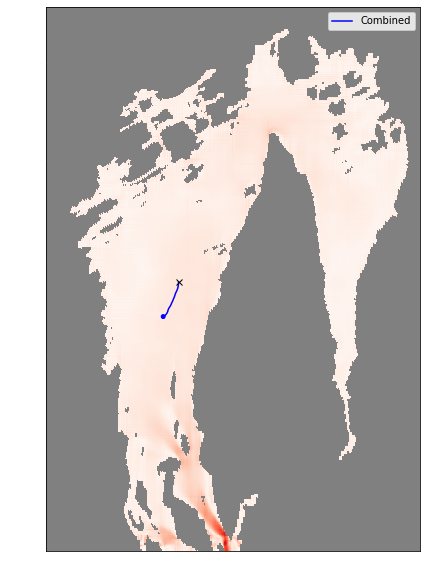

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

combined_eta, combined_u, combined_v = sims.download() 
uv_field = np.sqrt(combined_u**2 + combined_v**2)


domain_extent = [0, sims.nx*sims.dx, 0, sims.ny*sims.dy]

velo_cmap = copy.deepcopy(plt.cm.Reds)
velo_cmap.set_bad("grey", alpha = 1.0)

ax.imshow(uv_field, interpolation="none", origin='lower', 
                cmap=velo_cmap, 
                vmin=0.0, vmax=0.5, 
                extent=domain_extent)

drifter_path = trajectories.get_drifter_path(0, 0, sims.t, in_km = False)[0]

start_pos = drifter_path[0,:]
circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                100, color = 'blue',
                                                fill=True, zorder=10)
ax.add_patch(circ_start)

ax.plot(drifter_path[:,0], drifter_path[:,1], color="blue", ls="-", zorder=5, label="Combined")
end_pos = drifter_path[-1,:]
ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)


ax.legend(labelcolor="black")


## Cross Pert Drifters


The test scenario should be
- 2 barotropic simulations
- 3 baroclinic simulations (different `r`)
- 4 wind drift factors

In [22]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

A single observation and drifter object to start with

In [23]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': barotropic_sim.nx, 'ny': barotropic_sim.ny,
                'domain_size_x': barotropic_sim.nx*barotropic_sim.dx,
                'domain_size_y': barotropic_sim.ny*barotropic_sim.dy,
                'land_mask': barotropic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)


In [24]:
initx = [ 6000]
inity = [12000]

num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_sim.gpu_ctx, # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream)

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

Now, lets collect a bunch of observations and drifter instances in a list 

In [25]:
import pandas as pd 

In [26]:
ref_table = pd.DataFrame(columns=["drifter_id", "barotropic_id", "baroclinic_id", "wind_id"]).set_index("drifter_id")

In [27]:
for barotropic in range(2):
    for baroclinic in range(3):
        for wind in range(4):
            ref_table.loc[len(ref_table.index)] = [barotropic, baroclinic, wind]

In [28]:
ref_table

,barotropic_id,baroclinic_id,wind_id
drifter_id,,,
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,1,0
5,0,1,1
6,0,1,2
7,0,1,3
8,0,2,0


In [29]:
crossprod_trajectories = []
for cp in range(24):
    crossprod_trajectories.append(copy.deepcopy(trajectories))

In [30]:
crossprod_drifters = []
for cp in range(24): 
    drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_sim.gpu_ctx, # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream)

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossprod_drifters.append(drifters)

In [31]:
from gpuocean.SWEsimulators import CombinedCDKLM16

In [32]:
sims = CombinedCDKLM16.CombinedCDKLM16(barotropic_gpu_ctx, baroclinic_gpu_ctx, **NetCDFInitialization.removeCombinedMetadata(barotropic_data_args, baroclinic_data_args), dt=0.0)

Exception caught: Resetting to CUDA context baroclinic_gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1419790/1621949509.py", line 1, in <module>
    sims = CombinedCDKLM16.CombinedCDKLM16(barotropic_gpu_ctx, baroclinic_gpu_ctx, **NetCDFInitialization.removeCombinedMetadata(barotropic_data_args, baroclinic_data_args), dt=0.0)
TypeError: __init__() got an unexpected keyword argument 'nx'


TypeError: __init__() got an unexpected keyword argument 'nx'

In [ ]:
baroclinic_sim.dt